<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/ORIG_TextAnalysisWikipedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with Wikipedia

We'll build a function to crawl wikipedia: to scrape text from a page and then to find links to related pages and scrape text from them.

BLOCK 1. Installing and loading relevant libraries.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
import requests # This is the library for embedding HTTP calls in the notebook
from random import sample
import scipy as sp
from sklearn.manifold import MDS #plots results
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


In [ ]:
!pip install boilerpy3
from boilerpy3 import extractors

In [ ]:
# Block 1d: BeautifulSoup is a useful library for extracting HTML elements
!pip install bs4
from bs4 import BeautifulSoup

In [ ]:
# Import NLTK library
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')    # This is a useful way to remove non-content function words from the data.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

In [ ]:
!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
wnl = nltk.WordNetLemmatizer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))


BLOCK 2. Data acquisition.

First, we get the text and links from the main section of the topic page. Then we harvest the interal links -- those that point to other topics in Wikipedia. We iterate over that list and scrape the text from the main section of each page. Because Wikipedia pages contain a lot of links, we only go one step from the main topic page.

In [ ]:
# Send request to website
# Store pgs as BeautifulSoup
# Parse through HTML until you find desired section
URL = 'https://en.wikipedia.org/wiki/Democracy' #Here, we specify the page we want to start with, the topic page

try:
    response = requests.get(URL)
    topic_soup = BeautifulSoup(response.content, 'html.parser')

except:
    print("Can not open " + URL + ".")


In [ ]:
topic_paragraphs = []

if topic_soup.find(id="mw-content-text"):
    if not topic_soup.find("reflist reflist-columns references-column-width"):
        if not topic_soup.find("refbegin refbegin-columns references-column-width"):
            for para in topic_soup.find_all('p', class_=False):
                text = para.get_text()
                topic_paragraphs.append(text)



print(len(topic_paragraphs))

topic_text = BeautifulSoup(response.text, 'html.parser')
title = topic_soup.find(id="firstHeading").string

topic_links = []
for link in topic_soup.find_all('a', attrs={'href': re.compile("^/wiki/")}):
    if not re.search('\w+[:]', link.get('href')):
        topic_links.append(link.get('href'))

topic_links.remove('/wiki/Main_Page')
topic_content_links = set(topic_links)

print(title)
print(len(topic_links))
print(len(topic_content_links))
print(topic_content_links)

161
Democracy
2316
1611
{'/wiki/Hellenistic_religion', '/wiki/Cold_War', '/wiki/Aeschylus', '/wiki/Raymond_Aron', '/wiki/Western_dress_codes', '/wiki/Vatican_City', '/wiki/Polybius', '/wiki/Personal_property', '/wiki/Product_sample', '/wiki/Nieszawa_Statutes', '/wiki/Gustave_Le_Bon', '/wiki/Satellite_state', '/wiki/Max_Weber', '/wiki/Dieter_Nohlen', '/wiki/20th-century_Western_painting', '/wiki/Federal_government', '/wiki/Unitary_state', '/wiki/Thomas_Hobbes', '/wiki/Raymond_Plant,_Baron_Plant_of_Highfield', '/wiki/Leandro_Fern%C3%A1ndez_de_Morat%C3%ADn', '/wiki/Western_pattern_diet', '/wiki/Joshua_Reynolds', '/wiki/Ibn_Tufayl', '/wiki/Harper_v._Virginia_Board_of_Elections', '/wiki/Xenophon', '/wiki/Marxism', '/wiki/Authoritarianism', '/wiki/Islamism', '/wiki/Public_toilet', '/wiki/Pacific_Islands_Forum', '/wiki/Karl_Polanyi', '/wiki/Ignatius_Sancho', '/wiki/Condorcet%27s_jury_theorem', '/wiki/Vaikunda_Perumal_Temple,_Uthiramerur#Kudavolai_system', '/wiki/Environment_minister', '/wiki/

In [ ]:
# Go through pgs 1 at a time and harvest the text, but not the links
# Don't iterate more than 1 level
URLs = []

for item in topic_content_links:
    URLs.append('https://en.wikipedia.org' + item)

for url in URLs:
    try:
        response = requests.get(url)
        content_soup = BeautifulSoup(response.content, 'html.parser')

    except:
        print("Can not open " + url + ".")

    if content_soup.find(id="mw-content-text"):
        if not content_soup.find("reflist reflist-columns references-column-width"):
            if not content_soup.find("refbegin refbegin-columns references-column-width"):
                for para in content_soup.find_all('p', class_=False):
                    text = para.get_text()
                    topic_paragraphs.append(text)


print(len(topic_paragraphs))

83094


BLOCK 3. Data preparation.

Here, we take the text data we scraped and create a corpus data object and then a document-term matrix. (In this case, the "documents" are the paragraphs we scraped.) The dtm data are used to compute distances based on co-occurrence.

In [ ]:
topic_corpus = []

for text in topic_paragraphs:
    sentences = nltk.sent_tokenize(text)
    topic_paragraph = ''.join(sentences)
    topic_corpus.append(topic_paragraph)

print(len(topic_corpus))

83218


In [ ]:
# Convert corpus into document token matrix
# Adjust min/max parameters to change the amount of results
vectorizer = CountVectorizer(
    min_df=0.03,
    max_df=0.98,
    stop_words='english',
    ngram_range=(1,2)
    )

topic_tm = vectorizer.fit_transform(topic_corpus)

topic_feature_names = vectorizer.get_feature_names_out()

topic_dtm = pd.DataFrame(topic_tm.todense(), columns=topic_feature_names)
topic_dtm.head()

,10,according,act,american,based,began,british,called,century,church,...,used,various,war,way,western,work,world,wrote,year,years
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


In [ ]:
topic_tokens_present = np.where(topic_dtm.max() > 1 , True, False)
topictokenslimited_df = topic_dtm.loc[:, topic_tokens_present]
nullwords = ["wikipedia", "copyright", "10"]
for term in nullwords:
    topictokenslimited_df = topictokenslimited_df.drop(columns=[i for i in list(topictokenslimited_df.columns) if term in i])
topictokenslimited_df

,according,act,american,based,began,british,called,century,church,city,...,used,various,war,way,western,work,world,wrote,year,years
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,2,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83214,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
83215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create distance matrix
keyword_cofreq = topictokenslimited_df.T.dot(topictokenslimited_df)
keyword_dist = 1/keyword_cofreq
keyword_dist  # distance matrix

,according,act,american,based,began,british,called,century,church,city,...,used,various,war,way,western,work,world,wrote,year,years
according,0.000161,0.004016,0.002770,0.002179,0.005495,0.004878,0.002882,0.001678,0.002451,0.003436,...,0.002398,0.003745,0.002146,0.003125,0.002994,0.002174,0.000867,0.004237,0.003906,0.002519
act,0.004016,0.000123,0.002558,0.005208,0.004425,0.001229,0.004032,0.003067,0.005000,0.008696,...,0.003096,0.009259,0.002105,0.006329,0.013333,0.004717,0.003195,0.010753,0.003257,0.002375
american,0.002770,0.002558,0.000128,0.003401,0.002439,0.000758,0.002688,0.001205,0.004717,0.004000,...,0.002770,0.005405,0.000498,0.006494,0.002778,0.002326,0.001034,0.003012,0.003704,0.002283
based,0.002179,0.005208,0.003401,0.000187,0.005682,0.004184,0.003086,0.001631,0.003953,0.004717,...,0.002128,0.003774,0.002653,0.003953,0.003650,0.002160,0.001506,0.005917,0.005128,0.003311
began,0.005495,0.004425,0.002439,0.005682,0.000228,0.001883,0.003030,0.000860,0.003344,0.003236,...,0.003175,0.006757,0.000879,0.007246,0.002320,0.002415,0.001377,0.004717,0.002688,0.001821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
work,0.002174,0.004717,0.002326,0.002160,0.002415,0.004902,0.002110,0.001174,0.002770,0.004808,...,0.001980,0.004184,0.002227,0.002817,0.003472,0.000121,0.001198,0.001832,0.003584,0.001592
world,0.000867,0.003195,0.001034,0.001506,0.001377,0.000966,0.001672,0.000516,0.001894,0.001538,...,0.001250,0.001969,0.000188,0.001859,0.000597,0.001198,0.000050,0.002227,0.001582,0.001007
wrote,0.004237,0.010753,0.003012,0.005917,0.004717,0.005780,0.003333,0.002160,0.004608,0.007634,...,0.005181,0.012195,0.002364,0.005076,0.006849,0.001832,0.002227,0.000249,0.004762,0.002632
year,0.003906,0.003257,0.003704,0.005128,0.002688,0.003610,0.003521,0.003663,0.005556,0.003559,...,0.004425,0.007812,0.001675,0.007812,0.005263,0.003584,0.001582,0.004762,0.000198,0.001086


BLOCK 4. Analysis and visualization.

In [ ]:
# Multidimensional scaling
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
pca = PCA(n_components=2)
keywords_transform = mds.fit_transform(keyword_dist)
print(keywords_transform)
print(mds.stress_)

[[ 3.13518276e-02  3.09682430e-01]
 [ 1.03098299e-01  9.10866763e-02]
 [-1.11408808e-01  1.97840911e-01]
 [-5.16430473e-02  3.92526490e-01]
 [ 4.63831450e-01 -8.84382899e-02]
 [ 3.25431972e-01  7.37157333e-02]
 [ 5.19490901e-02  4.01824582e-01]
 [-3.78970132e-01 -2.83181305e-01]
 [-4.11220573e-01  2.63326561e-01]
 [ 2.45336509e-01  3.77141062e-01]
 [ 3.74682126e-01  3.03808621e-01]
 [-3.35132230e-02  3.46492563e-01]
 [-4.06163806e-01  1.05010464e-01]
 [-2.72617996e-01  3.63986077e-01]
 [-6.51810756e-02 -5.24726278e-02]
 [-2.12567144e-01  2.82637316e-01]
 [-1.07380183e-01  1.26791413e-01]
 [-4.37933861e-01  7.57809564e-02]
 [ 1.05456282e-01  2.25901683e-01]
 [ 4.20123413e-01  2.28185040e-01]
 [-1.95333843e-01  6.26444495e-03]
 [ 1.66485455e-01 -5.07636032e-01]
 [ 1.57060555e-01  2.61952456e-01]
 [-3.24548560e-01 -3.63916337e-01]
 [-2.45314290e-01 -9.93162468e-02]
 [-2.25540358e-02  7.16331591e-03]
 [ 4.89836447e-01 -3.47182915e-01]
 [-3.49293604e-01 -3.13950518e-01]
 [ 9.71548031e-02 -2

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


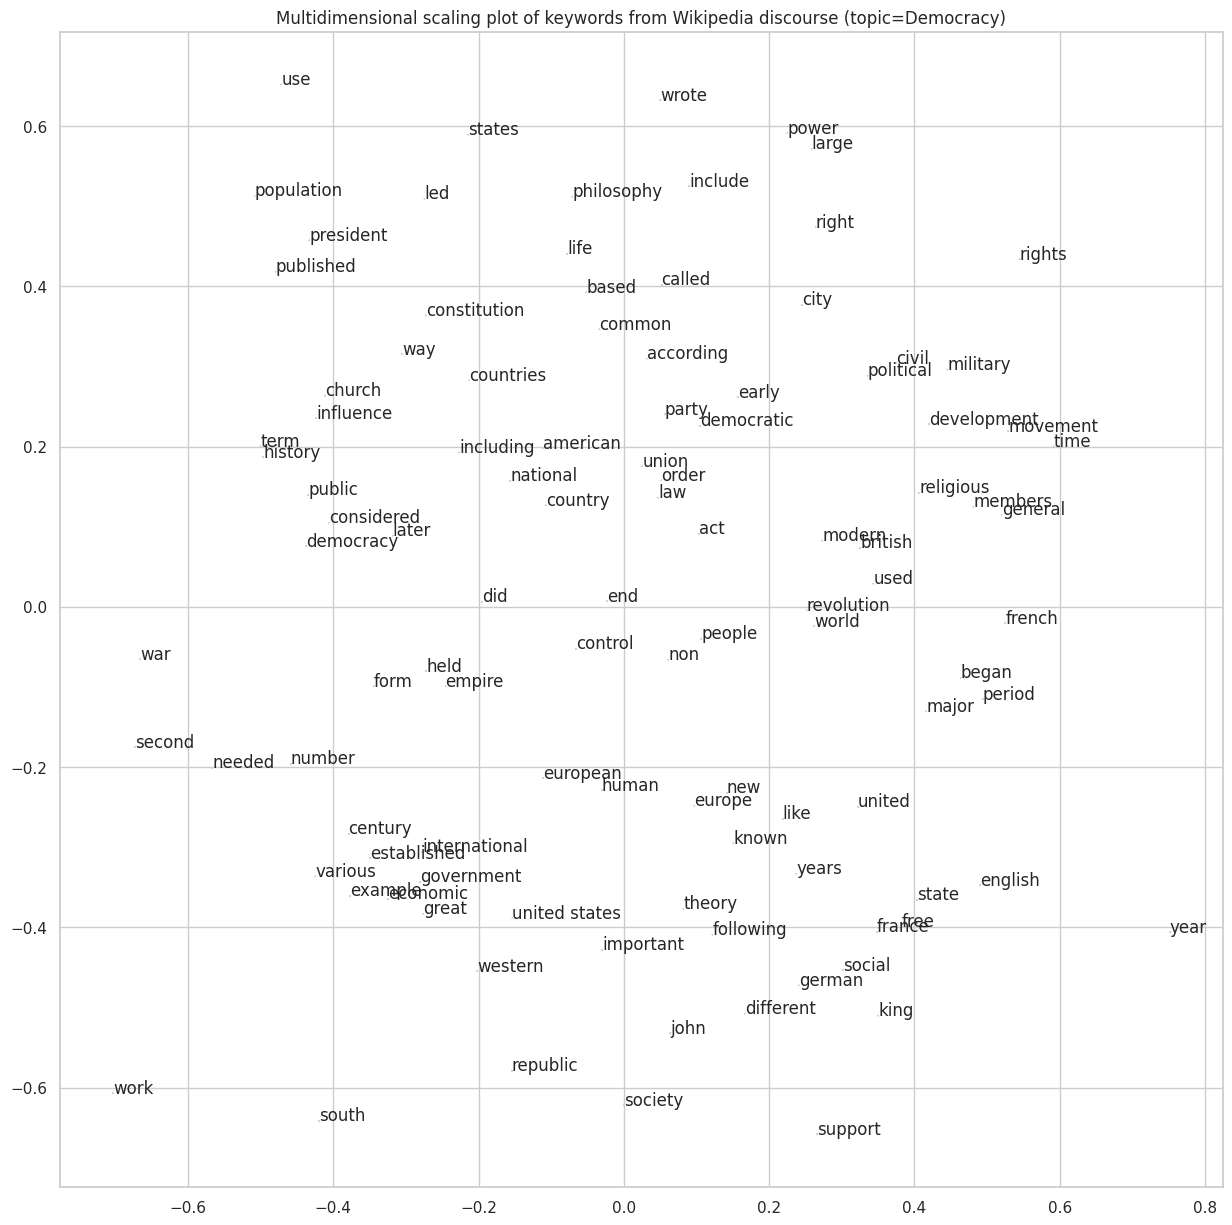

In [ ]:
# Plot results
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15,15))
i = 0
while i < len(topictokenslimited_df.columns):
    plt.scatter(keywords_transform[i,0], keywords_transform[i,1], sizes=(1, 1), marker='+', c='lightgrey')
    plt.text(keywords_transform[i,0], keywords_transform[i,1], topictokenslimited_df.columns[i])
    i += 1
plt.title('Multidimensional scaling plot of keywords from Wikipedia discourse (topic=Democracy)')
plt.show()